# Fire management- Trees mitigate

## Introduction

Mitigation is one the common techniques to control the wildfire. I am going to run the trees mitigate model to see how different scenarios can change the fire spread pattern.



## About the model
I assume that my study area has 10000 grids (100*100). Each grid has one tree. There are two kind of trees: young and old trees. At first, 10% of the study are is empty so we have 900 trees ( 900 grid cells). 

My main question is:
how does mitigation of young and old trees in the study area will effect the fire spread time?
for answering this question, I will compare 6 different scenarios:


At first, I have 6300 old trees and 2700 young trees ( all toghether 90% of the study area)
I mitigate the old trees. For every step I cutoff 1000 trees.


-- % of occupied grids show the percentage of full grids ( 90% meand 10% of pixels have no trees)
-- % of old trees shows how many of available tress are old.
-- the rule for young and old trees are different. If a pixel is on fire and it is old, it burned 5 neighboring pixels
   If a pixel is on fire and it is young, it can burn only 2 neighboring pixels.                                                 

| number of grids | % of occupied grides | % of old trees   | number of neighbors |
|-----------------|----------------------|--------------------|---------------------|
| 10000           | 90%                  | 70% ( 6300 trees)  | 5                |
| 10000           | 80%                  | 66% ( 5300 trees ) | 5                  |
| 10000           | 70%                  | 61% ( 4300 trees)  | 5                  |  

                              (Mitigating old trees)



In the next step, I mitigate young trees. at first I had 2700 young trees. In each step, I cuttoff 1000 young trees. 



| number of grid cells | % of occupied grides | % of young trees  | number of neighbors |
|----------------------|----------------------|-------------------|---------------------|
| 10000                | 90%                  | 30% ( 2700 trees) | 3 
| 10000                | 80%                  | 21% (1700 trees)  | 3                   |
| 10000                | 70%                  | 10% ( 700 trees)  | 3                  |


                             (Mitigating young trees)



In [5]:
import random

import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import mesa
from mesa import Model, Agent
from mesa.time import RandomActivation
from mesa.space import Grid
from mesa.datacollection import DataCollector
from mesa.batchrunner import BatchRunner

In [6]:
class TreeCell(Agent):
    '''
    A tree cell.
    
    Attributes:
        x, y: Grid coordinates
        condition: Can be "Fine", "On Fire", or "Burned"
        unique_id: (x,y) tuple. 
    
    unique_id isn't strictly necessary here, but it's good practice to give one to each
    agent anyway.
    '''
    def __init__(self, model, pos,agent_type):  # adding agent_type
        '''
        Create a new tree.
        Args:
            pos: The tree's coordinates on the grid. Used as the unique_id
        '''
        super().__init__(pos, model)
        self.pos = pos
        self.unique_id = pos
        self.condition = "Fine"
        self.agent_type= "Old"
        
    def step(self):
        '''
        If the tree is on fire, spread it to fine trees nearby.
        '''

        
        if self.condition == "On Fire" and self.agent_type=="Old":
            neighbors = self.model.grid.get_neighbors(self.pos, 5) # the rule for old trees is 5 neighboring pixels will burn
            for neighbor in neighbors:
                if neighbor.condition == "Fine":
                    neighbor.condition = "On Fire"
            self.condition = "Burned"


        if self.condition == "On Fire" and self.agent_type=="Young":  # for younf trees, just two neighboring pixels burn
            neighbors = self.model.grid.get_neighbors(self.pos, 2)
            for neighbor in neighbors:
                if neighbor.condition == "Fine":
                    neighbor.condition = "On Fire"
            self.condition = "Burned"

In [7]:
class ForestFire(Model):
    '''
    Simple Forest Fire model.
    '''
    def __init__(self, height, width, density, percentage1, percentage2):
        '''
        Create a new forest fire model.
        
        Args:
            height, width: The size of the grid to model
            density: What fraction of grid cells have a tree in them.
        '''
        # Initialize model parameters
        self.height = height
        self.width = width
        self.density = density
        self.percentage1 = percentage1
        self.percentage2 = percentage2
       
        
        # Set up model objects
        self.schedule = RandomActivation(self)
        self.grid = Grid(height, width, torus=False)
        self.dc = DataCollector({"Fine": lambda m: self.count_type(m, "Fine"),
                                "On Fire": lambda m: self.count_type(m, "On Fire"),
                                "Burned": lambda m: self.count_type(m, "Burned")})
        
        # Place a tree in each cell with Prob = density
        for x in range(self.width):
            for y in range(self.height):
                if random.random() < self.density:
                # Make tree old if random number is less than the property of the forest
                    if random.random() < self.percentage1:
                        agent_type = "Old"
                    else:
                        agent_type = "Young"
                    if random.random() < self.percentage2:
                        agent_type = "Young"
                    else:
                        agent_type = "Old"    
                    # Create a tree
                    new_tree = TreeCell(self, (x, y),agent_type)
                    # Set all trees in the first column on fire.
                    if x == 0:
                        new_tree.condition = "On Fire"
                    self.grid[y][x] = new_tree
                    self.schedule.add(new_tree)
        self.running = True
        

 
        
    def step(self):
        '''
        Advance the model by one step.
        '''
        self.schedule.step()
        self.dc.collect(self)
        # Halt if no more fire
        if self.count_type(self, "On Fire") == 0:
            self.running = False
           
    
    @staticmethod
    def count_type(model, tree_condition):
        '''
        Helper method to count trees in a given condition in a given model.
        '''
        count = 0
        for tree in model.schedule.agents:
            if tree.condition == tree_condition:
                count += 1
        return count

## Running the model

I run the ForestFirel model after mitigating old and young fire for 10%,20%,30%.

In [8]:
fire = ForestFire(100, 100, 0.9, 0.7,0.3)
fire.run_model()
results1 = fire.dc.get_model_vars_dataframe()
#results1.plot()
#plt.xlim(0,30)


In [9]:
fire = ForestFire(100, 100, 0.8, 0.66,0.33)
fire.run_model()
results2 = fire.dc.get_model_vars_dataframe()
#results2.plot()

In [10]:
fire = ForestFire(100, 100, 0.7,0.61 ,0.38)
fire.run_model()
results3= fire.dc.get_model_vars_dataframe()
#results3.plot()

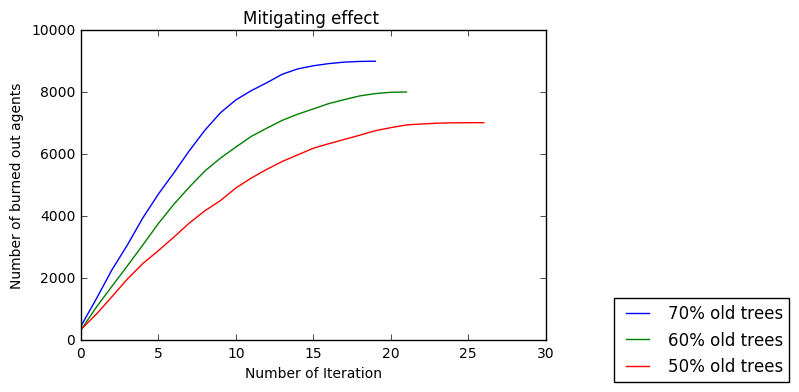

In [11]:
ax = plt.subplot(111)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels)


a =results1.Burned.plot(label="70% old trees")
b=results2.Burned.plot(label="60% old trees")
c=results3.Burned.plot(label="50% old trees")
plt.title('Mitigating effect ')
plt.ylabel('Number of burned out agents')
plt.xlabel('Number of Iteration')
plt.legend(bbox_to_anchor=(1, 0),loc=3,
           bbox_transform=plt.gcf().transFigure)
#plt.legend()
plt.xlim(0,30)

plt.show()



In [16]:
fire = ForestFire(100, 100, 0.9,0.7, 0.30)
fire.run_model()
results4 = fire.dc.get_model_vars_dataframe()
#results4.plot()

In [17]:
fire = ForestFire(100, 100, 0.8,0.78, 0.21)
fire.run_model()
results5 = fire.dc.get_model_vars_dataframe()
#results5.plot()

In [18]:
fire = ForestFire(100, 100, 0.7,0.9, 0.10)
fire.run_model()
results6 = fire.dc.get_model_vars_dataframe()
#results6.plot()

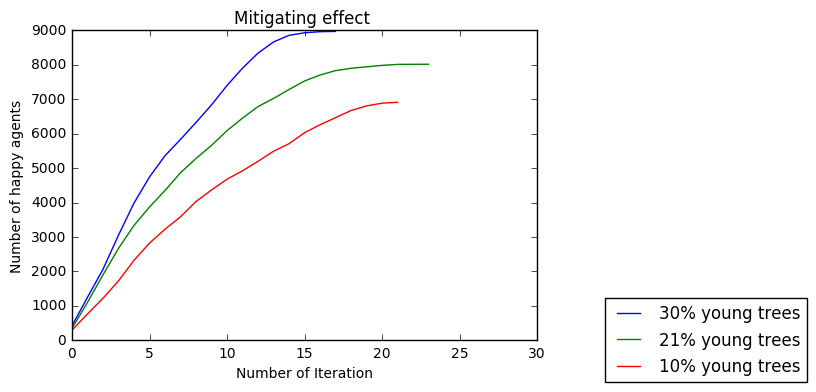

In [19]:
ax = plt.subplot(111)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels)


a =results4.Burned.plot(label="30% young trees")
b=results5.Burned.plot(label="21% young trees")
c=results6.Burned.plot(label="10% young trees")
plt.title('Mitigating effect ')
plt.ylabel('Number of happy agents')
plt.xlabel('Number of Iteration')
plt.legend(bbox_to_anchor=(1, 0),loc=3,
           bbox_transform=plt.gcf().transFigure)
#plt.legend()
plt.xlim(0,30)
#plt.legend()
plt.show()


## Batch runs

I used batch pocessing to see how different pecentage of old tree 

In [20]:
param_set = dict(height=100, # Height and width are constant
                 width=100,
                 # Vary density from 0.01 to 1, in 0.01 increments:
                 density=0.4,percentage2= 0,
                 percentage1=np.linspace(0,1,101))

In [21]:
# At the end of each model run, calculate the fraction of trees which are Burned
model_reporter = {"Burned": lambda m: (ForestFire.count_type(m, "Burned") / 
                                          m.schedule.get_agent_count()) }

In [22]:
# Create the batch runner
param_run = BatchRunner(ForestFire, param_set, model_reporters=model_reporter)

In [23]:
param_run.run_all()

100%|████████████████████████████████████████| 101/101 [01:03<00:00,  1.70it/s]


Like with the data collector, we can extract the data the batch runner collected into a dataframe:

In [24]:
df = param_run.get_model_vars_dataframe()

In [25]:
df.head()

,Burned,Run,density,height,percentage1,percentage2,width
0,0.972438,72,0.4,100,0.72,0,100
1,0.958843,3,0.4,100,0.03,0,100
2,0.968758,85,0.4,100,0.85,0,100
3,0.960618,62,0.4,100,0.62,0,100
4,0.977844,1,0.4,100,0.01,0,100


As you can see, each row here is a run of the model, identified by its parameter values (and given a unique index by the Run column). To view how the BurnedOut fraction varies with density, we can easily just plot them:

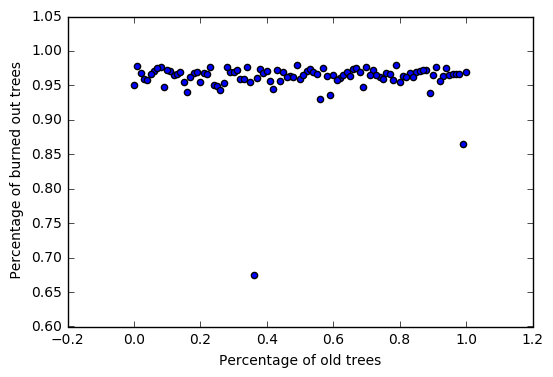

In [27]:
plt.scatter(df.percentage1, df.Burned)
#plt.xlim(0,10)
plt.ylabel(' Percentage of burned out trees')
plt.xlabel('Percentage of old trees')